In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, utils
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock, mutation_features, methylation_pred

/cellar/users/zkoch/miniconda3/envs/tf_env/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/cellar/users/zkoch/miniconda3/envs/tf_env/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from pyfaidx import Fasta


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


# Read TCGA data

In [3]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min


In [ ]:
analyze_comethylation = compute_comethylation.analyzeComethylation()
# distance
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/comparison_sites*")
m_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/mean_metrics_by_dist_w_weighted*")

In [6]:
all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    all_comparison_site_dfs.append(one_comp_df)
dist_all_comparison_site_df = pd.concat(all_comparison_site_dfs)
dist_all_comparison_site_df.reset_index(inplace=True, drop=True)

In [ ]:
"""dist_all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    dist_all_comparison_site_dfs.append(one_comp_df)
dist_all_comparison_site_df = pd.concat(dist_all_comparison_site_dfs)
dist_all_comparison_site_df.reset_index(inplace=True, drop=True)"""

"""dist_mean_metrics_df_l = []
for path in m_paths:
    # read in metrics sites from dask paruet
    one_metrics_df = pd.read_parquet(path)
    dist_mean_metrics_df_l.append(one_metrics_df)
dist_mean_metrics_df = pd.concat(dist_mean_metrics_df_l)"""

In [ ]:
dist_mean_metrics_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/mean_metrics_by_dist.parquet")
dist_all_metrics_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/dist_all_metrics_no_matchedSample.parquet")
dist_mean_metrics_w_mut_info_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/dist_mean_metrics_w_mut_info_df_10kb.parquet")

# Figure 2A: Supernova

-426 205 20
-19543
49406


/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:1007: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  labels = [f'{mutated_site_chr}:'+ format(mutated_site_start + distances[0], ','), mutated_site_chr + ':' + format(mutated_site_start, ',') , f'{mutated_site_chr}:'+ format(mutated_site_start + distances[-1], ',')]


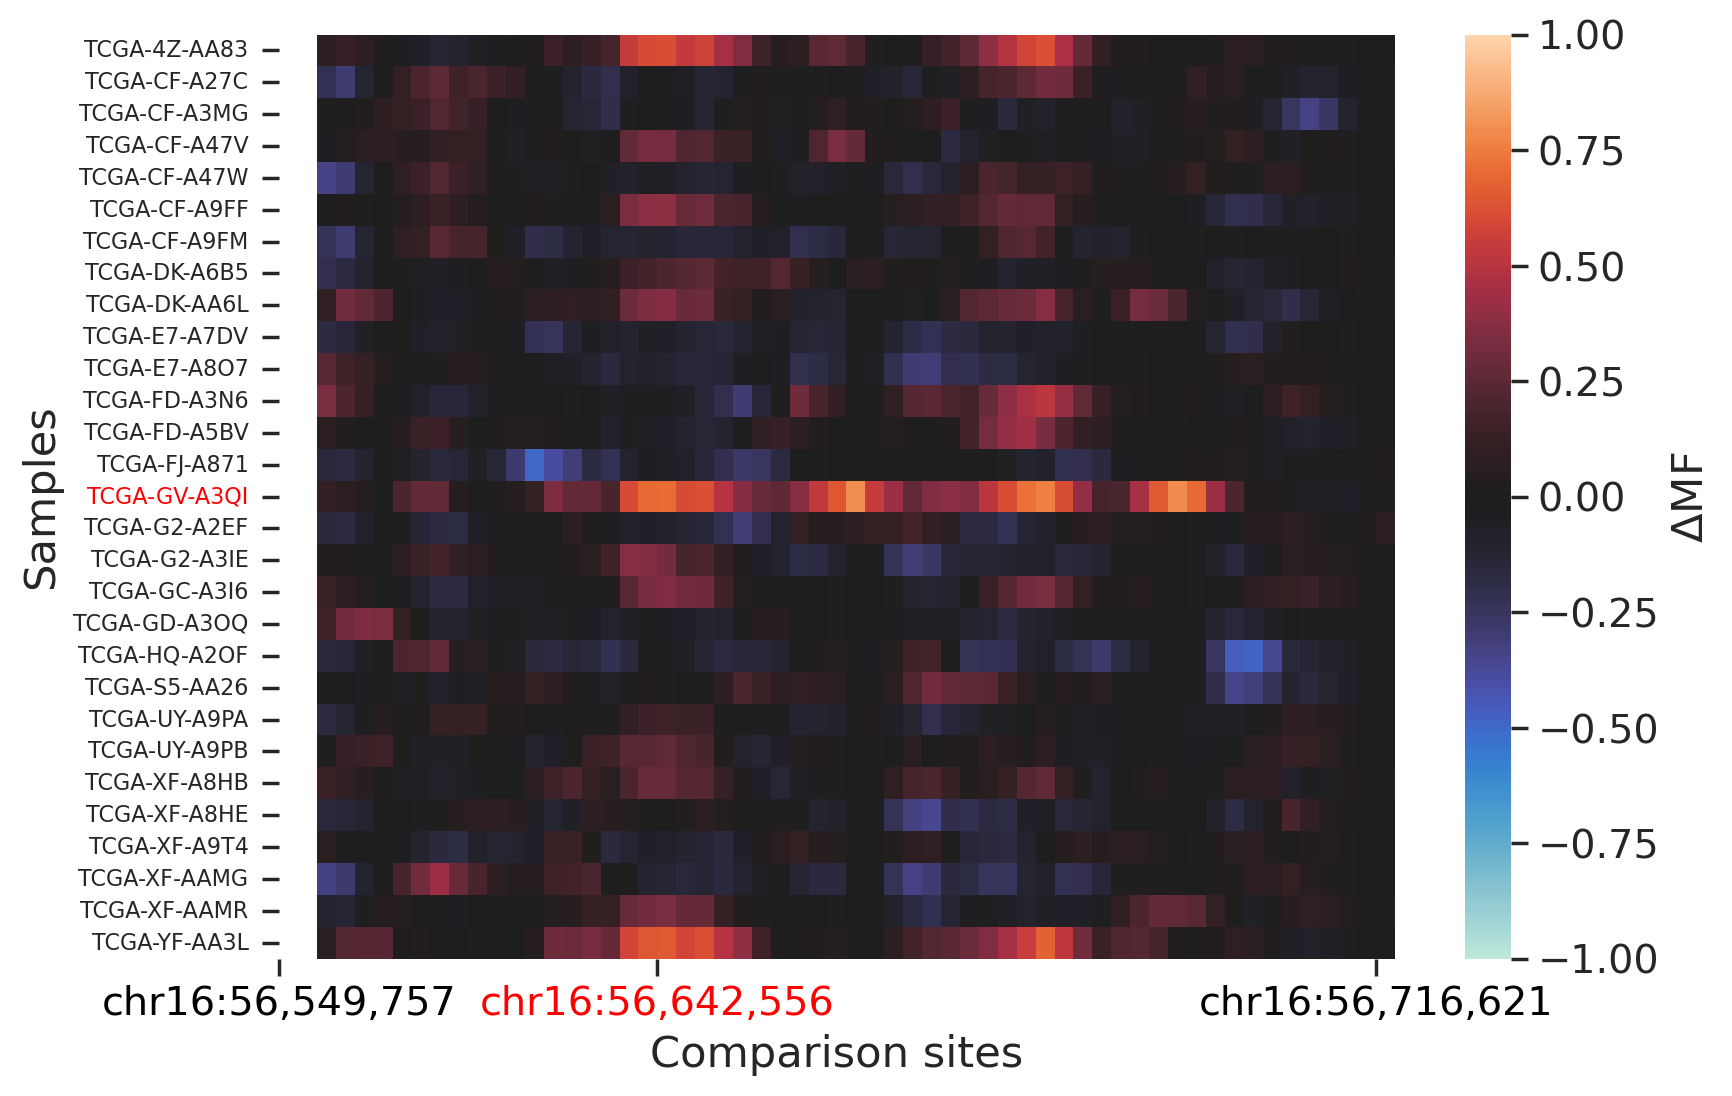

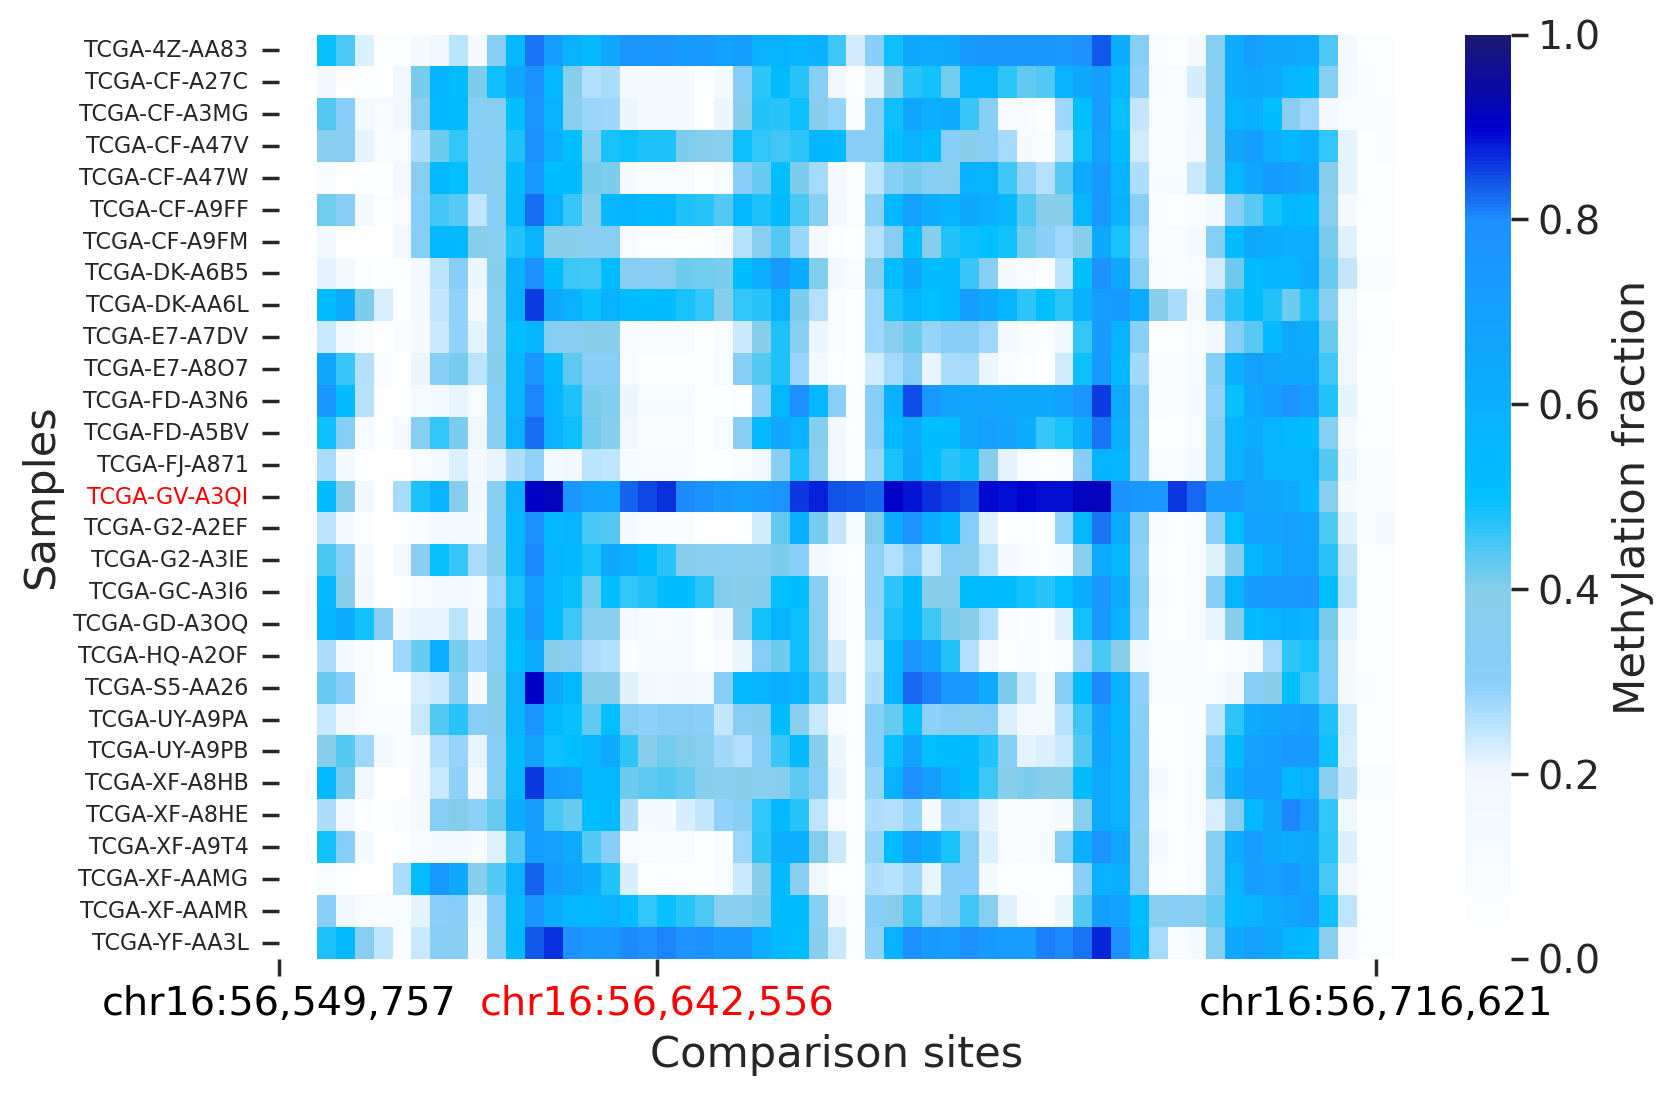

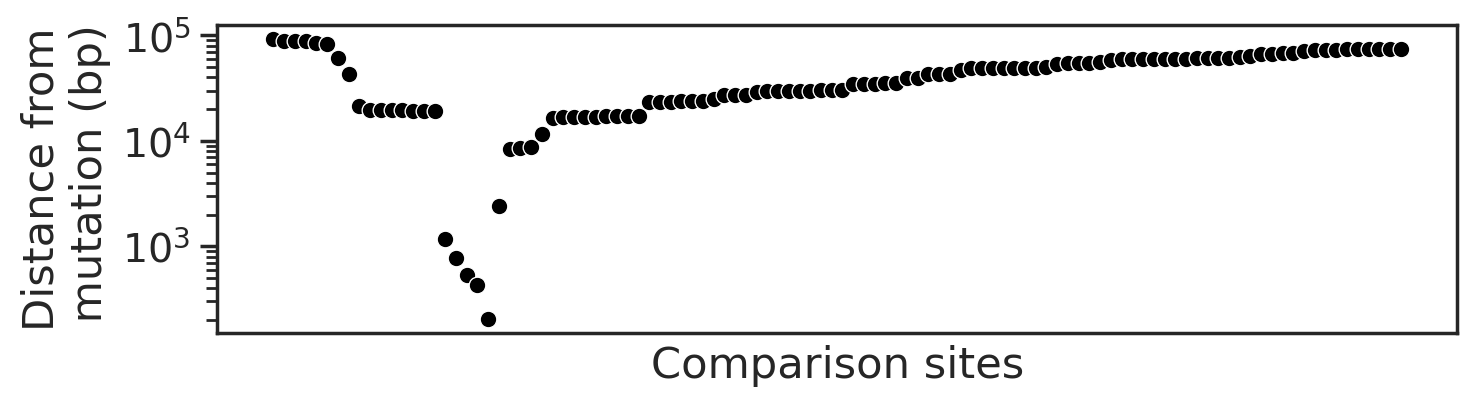

In [10]:
# best: TCGA-85-8352_5:140346535, TCGA-DX-AB30_18:56892844

# chosen: TCGA-D3-A3ML_15:25335137, TCGA-GV-A3QI_16:56642556 (comparison_sites[:-26])
# TCGA-95-7043_3:147128676
all_samples_comp_sites, all_samples_comp_sites_dmf, comparison_site_and_distances = analyze_comethylation.plot_heatmap_dist(
    mut_event = 'TCGA-GV-A3QI_16:56642556', comparison_sites_df = dist_all_comparison_site_df, 
    all_methyl_age_df_t = all_methyl_age_df_t,
    rolling_window_size = 3,
    max_matched_samples = 10000,
    max_abs_distance = 10e9
)